# `BUILDING A ML MODEL TO PREDICT CUSTOMER CHURN` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to predict the likelihood of retaining a customer

#### `Null Hypothesis`
There is no relationship between a tech savvy customer and the customer retention

#### `Alternate Hypothesis`
There is a relationship between a tech savvy customer and the customer retention

###### NB: A tech savvy person is someone who has online security or device protection or both

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;

• Model Accuracy : The ability of the machine learning model to accurately predict customer churn.

• Model Interpretability : The degree to which the model's predictions and insights can be understood and utilized by stakeholders.

• Business Impact : The effectiveness of retention strategies implemented based on the model's recommendations in reducing customer churn rates and improving overall customer satisfaction and retention.



#### `Analytical Questions`
- How does tenure and monthly charge affect customer churn?
- What is the likelihood of a customer with online security and protection to churn?
- What is the relationship between the type of contract and the likelihood of a customer churn?
- Do customers with dependents and internet security likely to Churn?

## `Data Understanding`

#### Data Source
The data was sourced from a Telecommunication company and divided into three (3) parts :
- 3000 rows as the training data
- 2000 rows as the evaluation data 
- 2000 rows as the test data 

### `Issues`
- Some columns have multiple adjectives of the same word. eg no,no internet service,false 


#### Data Exploration

##### `Libraries`

In [1]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import collections
import numpy as np

#Filter warnings
import warnings
warnings.filterwarnings('ignore')



from sklearn.model_selection import * #train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
#for balancing dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
#for feature selection
from sklearn.feature_selection import mutual_info_classif,SelectKBest
#Crossvalidation for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#joblib for model persit
import joblib

from sklearn.metrics import *
from sklearn.model_selection import * 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


##### `Database Connection`

In [2]:
#Access protocols for the SQL Database
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [3]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [4]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM LP2_Telco_churn_first_3000"

sql_df= pd.read_sql(query, connection)
sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [5]:
# Describing the SQL Dataframe
sql_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### `Accessing the second set of data in CSV format`

In [6]:
##Accessing the second set of data 
csv_df = pd.read_csv("data\\LP2_Telco-churn-second-2000.csv")
csv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [7]:
# Describing the Dataframe
csv_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### `Merging the Two Dataframes`

In [8]:
com_df=pd.concat([sql_df,csv_df],ignore_index=True)
com_df.head(5)
com_df.shape

(5043, 21)

In [9]:
#Checking the datatypes of the columns
datatypes = com_df.dtypes
datatypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

##### Converting the TotalCharges datatype to float64

In [10]:
#Converting TotalCharges column to numeric
com_df['TotalCharges'] = pd.to_numeric(com_df['TotalCharges'], errors='coerce')
com_df=com_df.reset_index()

In [11]:
# Checking the Null value
com_df.isnull().sum()

index                 0
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [12]:
com_df.head(5)
data=com_df.copy()

In [13]:
#Dropping the index column
com_df = com_df.drop(['index'], axis = 1 )

##### Replacing all negatives with False and positives with True

In [14]:
com_df.replace(['No','No internet service','false','No phone service'], "False", inplace = True)

com_df.replace('Yes',"True", inplace = True)



In [15]:
com_df['SeniorCitizen'] = np.where(com_df['SeniorCitizen'] == 1, True, False)


In [16]:
com_df.InternetService.replace('false','None')

0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
           ...     
5038            DSL
5039    Fiber optic
5040            DSL
5041    Fiber optic
5042    Fiber optic
Name: InternetService, Length: 5043, dtype: object

In [17]:
datatypes = com_df.dtypes
datatypes

customerID           object
gender               object
SeniorCitizen          bool
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

##### Making the True/False to Boolean

In [18]:
com_df.replace({'True': True, 'False': False}, inplace = True)

In [19]:
com_df.to_csv("data/customer_churn_merged")

### Univariate Analysis

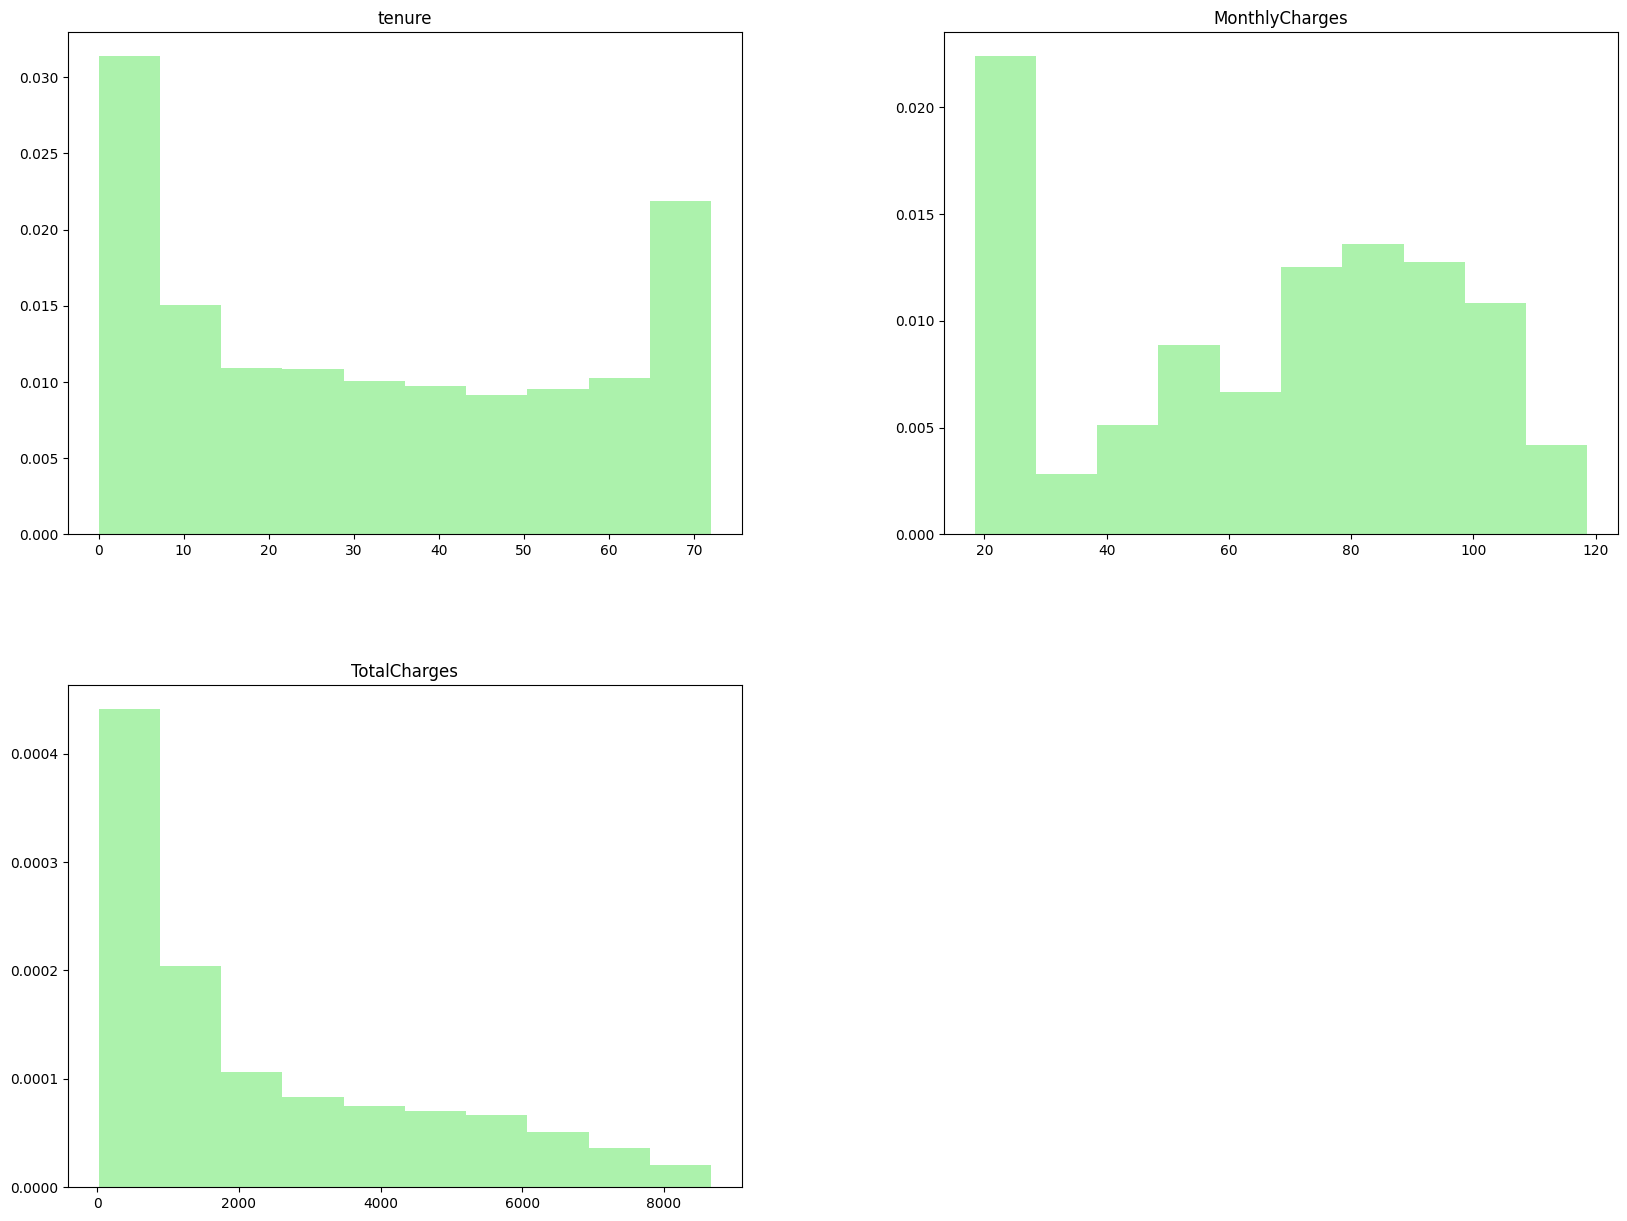

In [20]:
# Distribution of the variables
com_df.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()

In [21]:
# Visualize the distribution of categorical columns
categoricals = [column for column in com_df.columns if com_df[column].dtype == "O"]
for column in categoricals:
        if column not in ['customerID']:
                fig = px.histogram(com_df, x = com_df[column], text_auto = True,color = column,
                               title = f"Distribution of customers based on {column}")
                fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_tickangle = -45)
                fig.show()


#### OBSERVATION
- The Gender is evenly distributed 
- Over 50% of all contract types are month-on-month basis
- Electronic Check is the most used,covering 30% of all payment methods


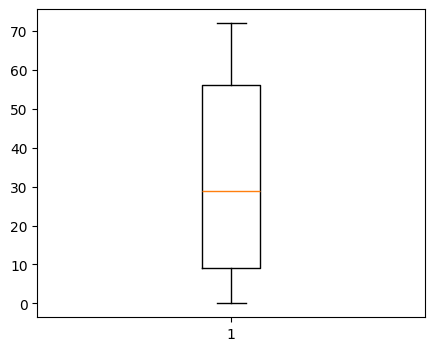

In [22]:
fig = plt.figure(figsize = (5, 4))
 
# Creating plot
plt.boxplot(com_df.tenure)
plt.show()

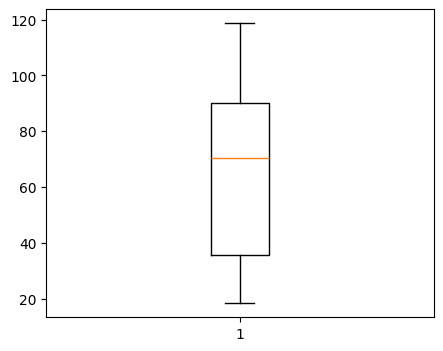

In [23]:
fig = plt.figure(figsize = (5, 4))
 
# Creating plot
plt.boxplot(com_df.MonthlyCharges)
plt.show()

### Bivariate Analysis

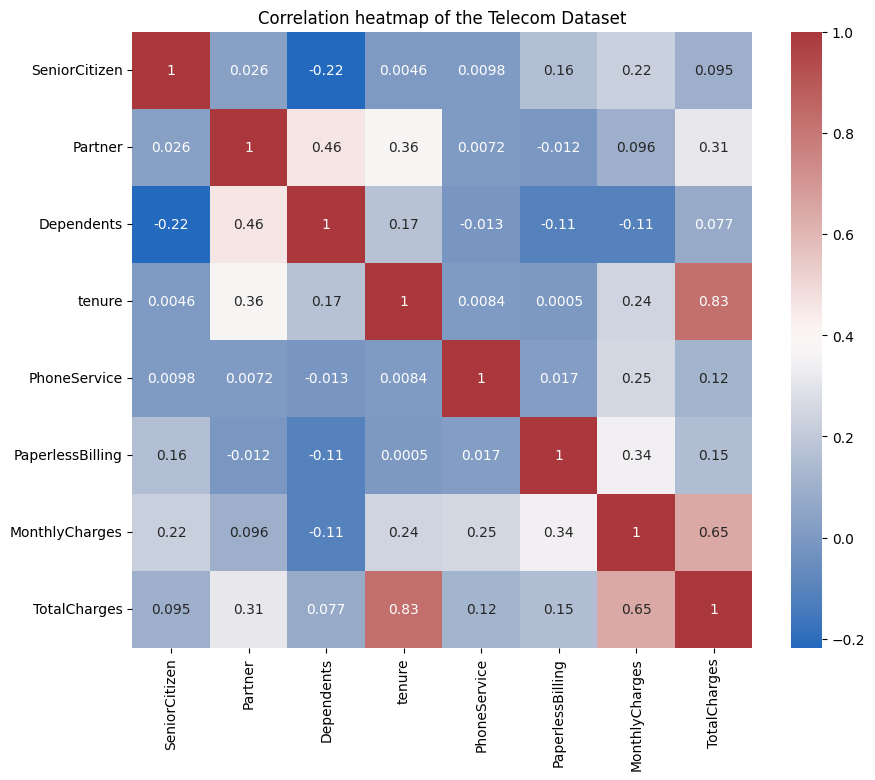

In [24]:
# Summarizing the relationships between the variables with a heatmap of the correlations
correlation_matrix = com_df.corr(numeric_only = True)
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True,cmap = 'vlag')
plt.title("Correlation heatmap of the Telecom Dataset")
plt.show()

 ## `Answering the Analytical Questions`


##### `How does tenure and monthly charge affect customer churn?`


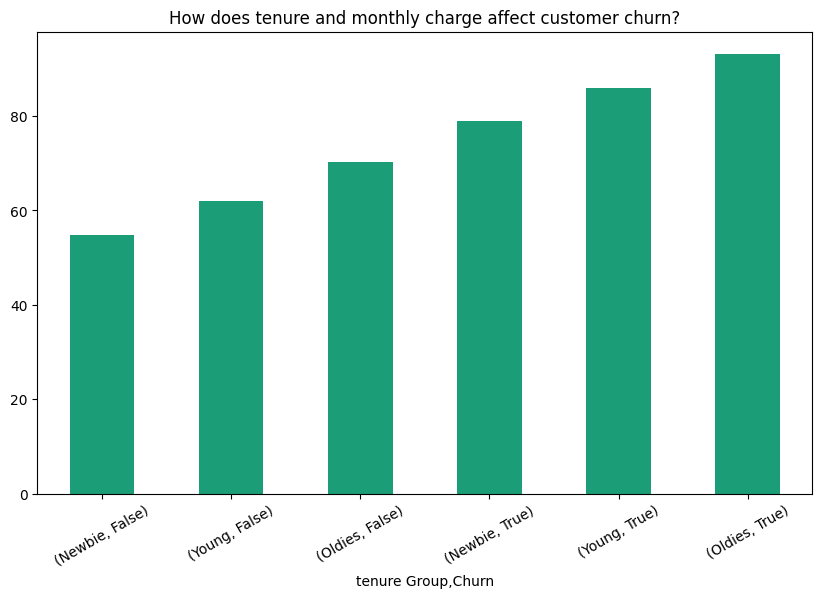

In [25]:

bins = [ 10, 30, 50,70]
df = com_df
labels = ['Newbie', 'Young', 'Oldies']
df['tenure Group'] = pd.cut(df['tenure'], bins = bins, labels = labels)
streamers = com_df.groupby(['tenure Group','Churn'])['MonthlyCharges'].mean().sort_values(ascending = True)

streamers.plot(kind='bar', title = 'How does tenure and monthly charge affect customer churn?', figsize = (10,6), cmap='Dark2', rot = 30)

plt.show()


#### OBSERVATION
- New,Existing and Old Customers with higher charges for software usage are the ones churning.
- There has to be a loyalty promotion for old customers to lock in the old customers.
- There can also be a signup discount to new customers to lock them in on the software.

##### `What is the likelihood of a customer with online security and device protection to churn?`


<Axes: title={'center': 'The likelihood of a customer with online security and device protection to churn'}, xlabel='OnlineSecurity,DeviceProtection'>

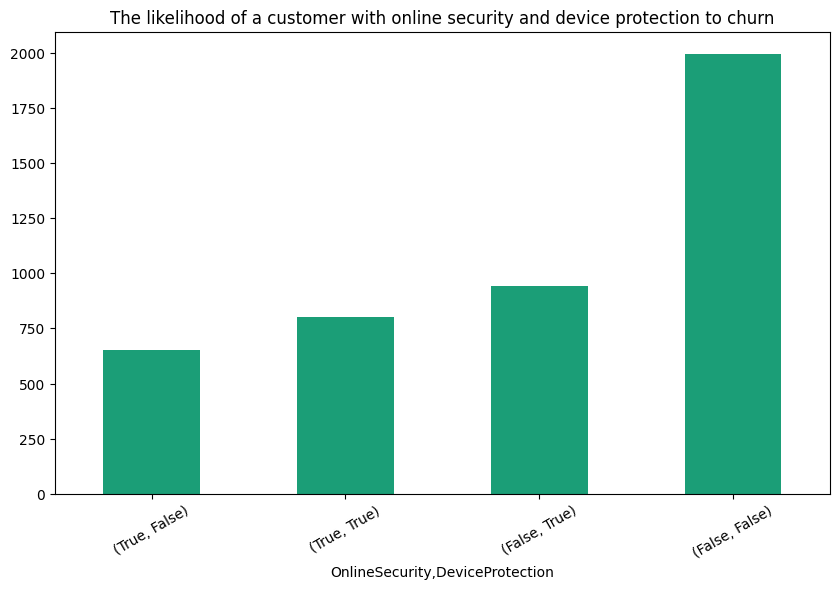

In [26]:
cust_retention = com_df.groupby(['OnlineSecurity','DeviceProtection'])['Churn'].count().sort_values(ascending = True)
cust_retention.plot(kind = 'bar', title = 'The likelihood of a customer with online security and device protection to churn', figsize = (10,6), cmap = 'Dark2', rot = 30)

#### OBSERVATION
- Customers with no security at all are more likely to Churn. 
- Basic cybersecurity can be done to curb customer doubt to reduce Churn.

#### `What is the relationship between the type of contract and the likelihood of a customer churn?`


<Axes: title={'center': 'The relationship between the type of contract and the likelihood of a customer churn'}, xlabel='Contract'>

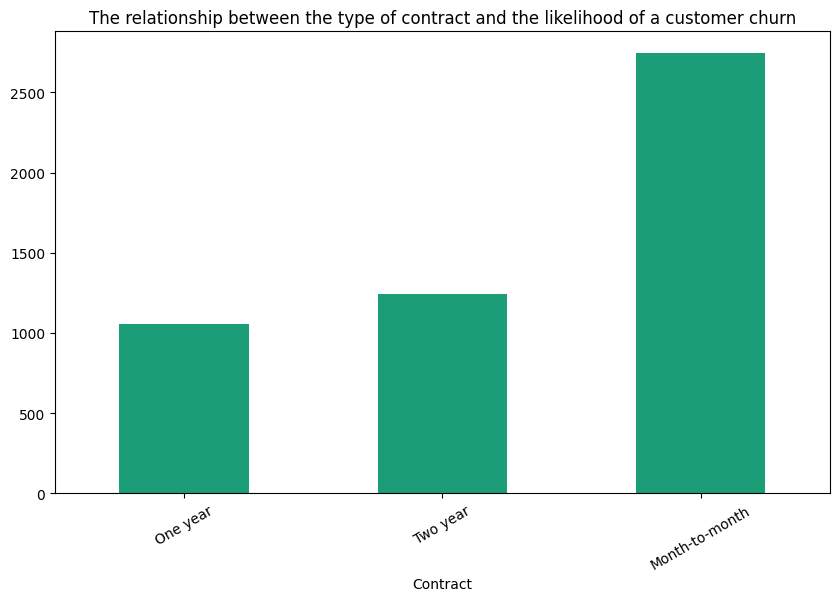

In [27]:
cust_contract = com_df.groupby('Contract')['Churn'].count().sort_values(ascending = True)
cust_contract.plot(kind = 'bar', title = 'The relationship between the type of contract and the likelihood of a customer churn', figsize = (10,6), cmap = 'Dark2', rot = 30)

#### OBSERVATION
- Month-to-Month Customers are more likely to churn as they are likely to be floating users.

#### `Do customers with dependents and internet security likely to Churn?`

<Axes: title={'center': 'Do customers with dependents and internet security likely to Churn?'}, xlabel='OnlineSecurity,Dependents'>

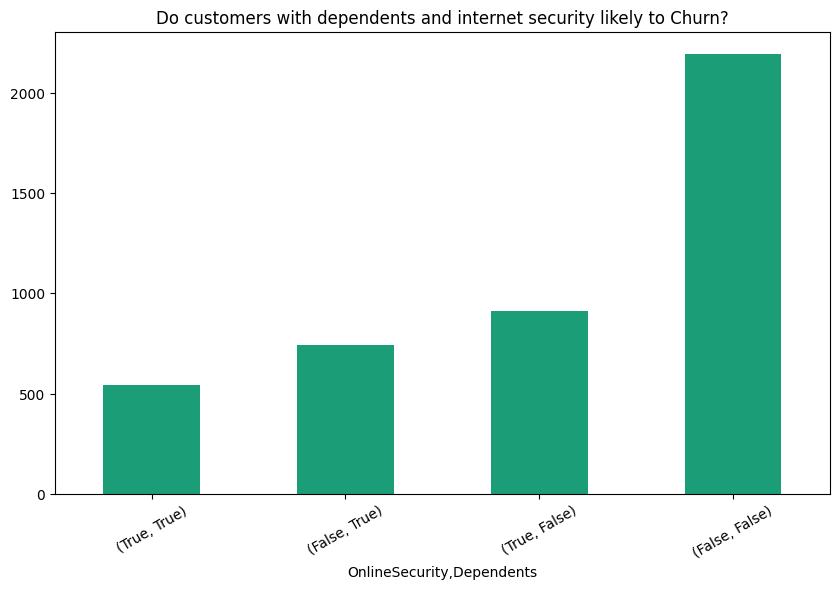

In [28]:
cust_contract = com_df.groupby(['OnlineSecurity','Dependents'])['Churn'].count().sort_values(ascending = True)
cust_contract.plot(kind='bar', title = 'Do customers with dependents and internet security likely to Churn?', figsize = (10,6), cmap = 'Dark2', rot = 30)

#### OBSERVATION
Customers with both Online Security and Dependents are less likely to churn.

In [29]:
com_df.isnull().sum()


customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines        269
InternetService        0
OnlineSecurity       651
OnlineBackup         651
DeviceProtection     651
TechSupport          651
StreamingTV          651
StreamingMovies      651
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           8
Churn                  1
tenure Group        1764
dtype: int64

In [30]:
#Dropping Empty rows
com_df = com_df.dropna(subset=['OnlineSecurity','OnlineBackup','DeviceProtection','MultipleLines','TotalCharges','Churn'],axis = 0)

In [31]:
#finding duplicates
duplicate = com_df[com_df.duplicated()]
duplicate.shape

(0, 22)

##### OBSERVATION 
No duplicates found

#### `HYPOTHESIS`

In [32]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality = stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality < 0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [33]:
#Hypothesis

df_tech = com_df.loc[com_df.OnlineSecurity & com_df.DeviceProtection]
online = com_df.loc[com_df.OnlineSecurity]
device = com_df.loc[com_df.DeviceProtection]


In [34]:
#Normality Checks
check_normality(df_tech.TotalCharges,'Online Security and Device Protection')
check_normality(online.TotalCharges,'Online Security')
check_normality(device.TotalCharges,'Device Protection')

p value:0.00000000001746254682
Reject null hypothesis >> The data for Online Security and Device Protection is not normally distributed
p value:0.00000000000000000142
Reject null hypothesis >> The data for Online Security is not normally distributed
p value:0.00000000000000000001
Reject null hypothesis >> The data for Device Protection is not normally distributed


In [35]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene = stats.levene(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene < 0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0001300041
Reject null hypothesis >> The variances of the samples are different.


##### Observation 
- Data samples are not normally distributed
- The variances of the samples are different
- Therefore a Non-Parametric test must be done (Kruskal Test)

In [36]:
#Kruskal Test

stat, p = kruskal(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges)
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=84.496, p=0.000000000000000
One or more sample distributions are not equal distributions (reject null Hypothesis)


##### OBSERVATION
Reject the null Hypothesis

### `Data preparation`

#### Feature Correlation and Selection

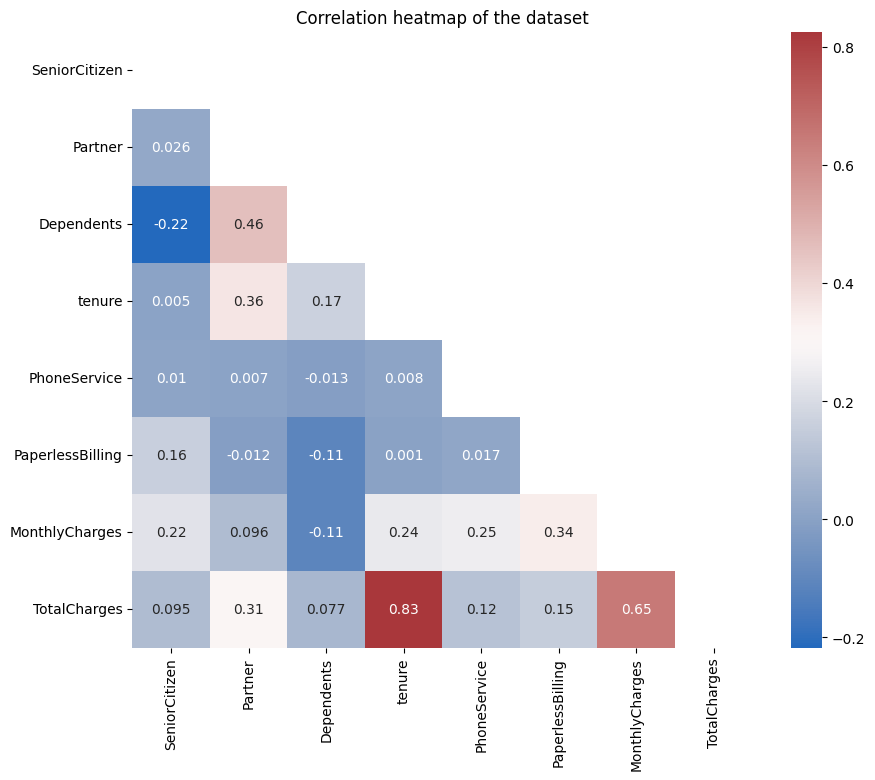

In [37]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [38]:

df.head(1)
df1 = data.drop(columns=['index','customerID','gender','TotalCharges'],axis=1)

In [39]:
# Dropping row with null value
df1.dropna(axis = 0, inplace = True)

In [40]:
def str_convert(df,column_name):
    df[column_name]=df[column_name].replace({1: 'Yes', 0: 'No'})

    return df

In [41]:
df1 = str_convert(df1,'SeniorCitizen')


df1=df1.map(lambda x: 'Yes' if x == True else 'No' if x == False else x)


df1['tenure'] = pd.to_numeric(df1['tenure'], errors = 'coerce', downcast = 'integer')


In [42]:
def cleaner (df):
    df = df.drop(columns=['customerID','gender','TotalCharges'],axis=1)
    df['SeniorCitizen']=df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})
    df=df.map(lambda x: 'Yes' if x == True else 'No' if x == False else x)
    df['tenure'] = pd.to_numeric(df['tenure'], errors = 'coerce', downcast = 'integer')

    return df

#### `Distribution of the dependent variable`

##### Dataset classification

- Checking to see if the binary dependent variables are evenly distributed or not 
- With the current levels of disparity between the two classes what stratification method will be best


In [43]:
# Separate majority and minority classes
df1_stay = df1[df1.Churn== 'No']
df1_left = df1[df1.Churn=="Yes"]

print((len(df1_stay)/len(df1)),(len(df1_left)/len(df1)))
print(len(df1_left))

0.7011159631246967 0.29888403687530324
1232


##### Observation
- About 70% of the customers stayed as compared to the customers that left therefore the churned customers represent the minority group
- Using undersampling means there will a huge loss of the majority class to balance the data
- Using oversampling means that there will  be a too many duplicates of the minority class in the balanced data 
- For this dataset, it will be best to use SMOTE to balance the dataset

In [44]:
df1.dtypes

SeniorCitizen        object
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

In [45]:
df1.head(4)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
1,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,No
2,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,Yes
4,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,Yes
5,No,No,No,8.0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,Yes


#### `Modeling`

In [46]:
df1.dtypes

SeniorCitizen        object
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

In [47]:
# Dropping row with null value
df1.dropna(axis = 0, inplace = True)

In [48]:
X=df1.drop(columns=['Churn'],axis=1)
y=df1['Churn'].replace({'Yes': 1, 'No': 0})


In [49]:
# Looking at the descriptive statistics of the columns with categorical values
cats = [column for column in X.columns if (X[column].dtype == "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df1[cats].describe(include="all")

Summary table of the Descriptive Statistics of Columns with Numeric Values


,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776,3776
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,No,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
freq,3071,1957,2639,3575,1914,2081,2081,1812,1798,2043,1779,1798,2042,2428,1357


In [50]:
# Looking at the descriptive statistics of the columns with numeric values
numerics = [column for column in X.columns if (X[column].dtype != "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df1[numerics].describe()

Summary table of the Descriptive Statistics of Columns with Numeric Values


,tenure,MonthlyCharges
count,3776.000000,3776.000000
mean,35.738877,74.901814
std,23.584025,26.103236
min,2.000000,18.550000
25%,13.000000,59.450000
50%,34.000000,80.099998
75%,58.000000,94.949997
max,72.000000,118.650002


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 27)

In [52]:
y_train_encoded = pd.to_numeric(y_train)
y_test_encoded = pd.to_numeric(y_test)


##### `Making pipelines`


In [53]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# putting numeric columns to scaler and categorical to encoder
num_transformer = Pipeline(steps = [
     ('num_imputer', SimpleImputer(strategy = 'median')),
    ('num', scaler)
])
cat_transformer = Pipeline(steps = [
   ('cat_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('cat', encoder)
])


In [54]:
# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers = [('num', num_transformer , numerics),
                    ('cat', cat_transformer , cats),
     
                    ])

In [55]:
#Calling the models of interest

log_mod =  (LogisticRegression(random_state = 27 ))
svc_mod = SVC(random_state=27,probability= True)

catboost_mod = (CatBoostClassifier(random_state=27, verbose = False))
xgboost_mod = XGBClassifier(random_state=27)
 

In [56]:
# Create a dictionary of the model pipelines
all_models_pipelines = {"Logistic_Regressor": (LogisticRegression(random_state = 27 )),
              "SVM": SVC(random_state = 27,probability = True),
              "CatBoost": (CatBoostClassifier(random_state=27, verbose = False)),
              "Xgboost":XGBClassifier(random_state=27)
              }
    

In [57]:
# Create a function to model and return comparative model evaluation scores,perform the SMOTE on each model pipeline,to calculate and compare accuracy

def evaluate_models(model_pipelines = all_models_pipelines, X_test = X_test, y_test = y_test_encoded):


    # Dictionary for trained models
    trained_models = dict()

    # Create a dataframe matrix to all pipelines
    all_confusion_matrix = []
    
    
    # List to receive scores
    performances = []
    for name, model_pipeline in model_pipelines.items():
        final_pipeline = imbpipeline(steps=[("preprocessor", preprocessor), 
                                   ('smote-sampler',SMOTE(random_state = 0)),
                                   ("feature_selection",SelectKBest(mutual_info_classif, k = 'all')),
                           ("model", model_pipeline)])
    


        
        final_pipeline.fit(X_train,  y_train)
       

        # Predict and calculate performance scores
        y_pred = final_pipeline.predict(X_test)
        performances.append([name,
                             accuracy_score(y_test, y_pred),  # accuracy
                             precision_score(y_test, y_pred, average="weighted"),  # precisions
                             recall_score(y_test, y_pred,average="weighted"),  # recall
                             f1_score(y_test, y_pred, average="weighted")
                             ])

        # Print classification report
        model_pipeline_report = classification_report(y_test, y_pred)
        print("This is the classification report of the",name, "model", "\n", model_pipeline_report, "\n")

        # Defining the Confusion Matrix
        model_pipeline_conf_mat = confusion_matrix(y_test, y_pred)
        model_pipeline_conf_mat = pd.DataFrame(model_pipeline_conf_mat).reset_index(drop = True)
        print(f"Below is the confusion matrix for the {name} model")

        # Visualizing the Confusion Matrix
        f, ax = plt.subplots()
        sns.heatmap(model_pipeline_conf_mat, annot = True, linewidth = 1.0,fmt = ".0f", cmap = "RdPu", ax=ax)
        plt.xlabel = ("Prediction")
        plt.ylabel = ("Actual")
        plt.show()

        # Store trained model
        trained_model_name = "trained_" + str(name).lower()
        trained_models[trained_model_name] = final_pipeline
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6)
    
    # Compile accuracy
    df_compare = pd.DataFrame(performances, columns = ["model", "accuracy", "precision", "recall", "f1_score"])
    df_compare.set_index("model", inplace = True)
    df_compare.sort_values(by = ["f1_score", "accuracy"], ascending = False, inplace=True)
    return df_compare, trained_models

This is the classification report of the Logistic_Regressor model 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1386
           1       0.52      0.78      0.62       502

    accuracy                           0.75      1888
   macro avg       0.71      0.76      0.72      1888
weighted avg       0.80      0.75      0.76      1888
 

Below is the confusion matrix for the Logistic_Regressor model


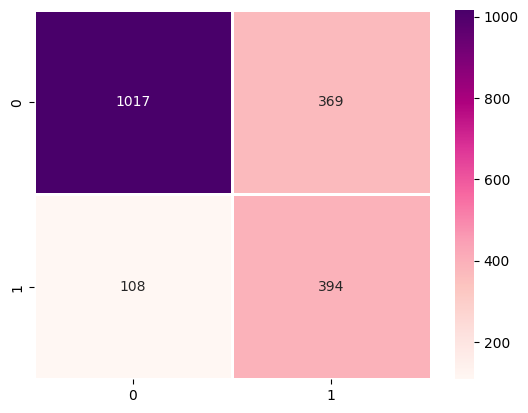


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----


This is the classification report of the SVM model 
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      1386
           1       0.52      0.73      0.61       502

    accuracy                           0.75      1888
   macro avg       0.70      0.74      0.71      1888
weighted avg       0.79      0.75      0.76      1888
 

Below is the confusion matrix for the SVM model


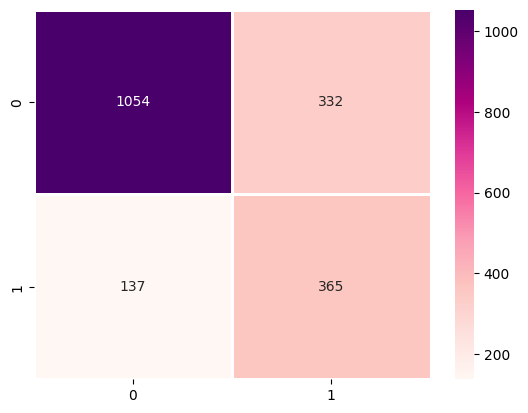


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
This is the classification report of the CatBoost model 
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1386
           1       0.58      0.57      0.57       502

    accuracy                           0.77      1888
   macro avg       0.71      0.71      0.71      1888
weighted avg       0.77      0.77      0.77      1888
 

Below is the confusion matrix for the CatBoost model


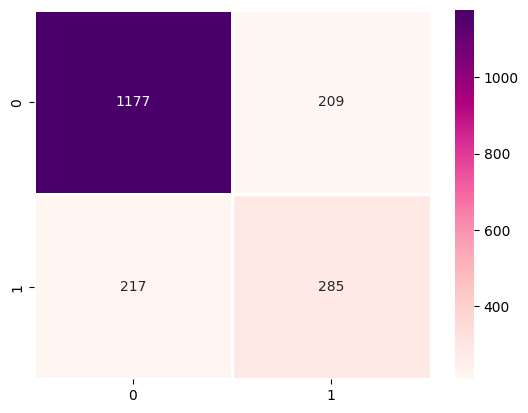


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
This is the classification report of the Xgboost model 
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      1386
           1       0.52      0.51      0.52       502

    accuracy                           0.75      1888
   macro avg       0.67      0.67      0.67      1888
weighted avg       0.74      0.75      0.75      1888
 

Below is the confusion matrix for the Xgboost model


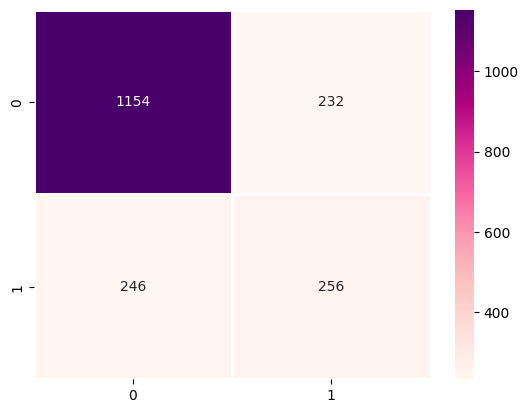


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----


,accuracy,precision,recall,f1_score
model,,,,
CatBoost,0.774364,0.773231,0.774364,0.773783
SVM,0.751589,0.788905,0.751589,0.762391
Logistic_Regressor,0.747352,0.800937,0.747352,0.760285
Xgboost,0.746822,0.744600,0.746822,0.745668


In [58]:
# Run the function to train models and return performances
all_models_eval, trained_models = evaluate_models()
all_models_eval

#### `Visualizing Evaluation Using ROC - AUC`

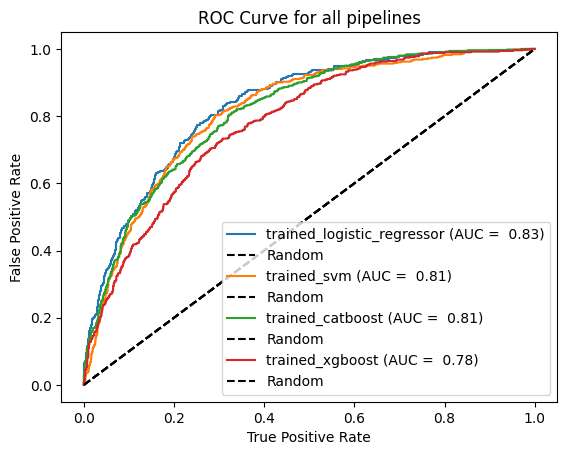

In [59]:
from sklearn.metrics import roc_curve,auc

all_roc_data = {}
fig, ax = plt.subplots()

for name,model in trained_models.items():
    y_score = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_score)

    roc_auc = auc(fpr,tpr)
    roc_data_df = pd.DataFrame({'False Positive Rate' : fpr , 'True Positve Rate' : tpr , 'Threshold' : thresholds})
    all_roc_data[name] = roc_data_df

    ax.plot(fpr,tpr, label = f'{name} (AUC = {roc_auc: .2f})')

    ax.plot([0,1],[0,1], linestyle='--', color='k', label='Random')
    ax.set_ylabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title('ROC Curve for all pipelines')

plt.legend()
plt.show()

In [60]:

lr_roc_data = all_roc_data["trained_logistic_regressor"]
svm_roc_data = all_roc_data["trained_svm"]
catboost_roc_data = all_roc_data["trained_catboost"]
xgboost_roc_data = all_roc_data["trained_xgboost"]

##### `Business Impact Assessment`

- The true positive rate is sensitive but there is a need to raise its sensitivity higher for production
- The acceptable threshold to meet the criteria is 0.4812 for the Logistic Regression model
- The acceptable threshold to meet the criteria is 0.3703 for the SVM model
- The acceptable threshold to meet the criteria is 0.2398 for the Cat Boost model
- The acceptable threshold to meet the criteria is 0.2189 for the Xgboost model


#### `Hyperparameter Tuning`

In [61]:
## XGBoost Classifier
xgb_clf = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model", XGBClassifier(random_state=27))])

# Defining the values for the RandomizedSearchCV
param_grid_xgboost = {"model__learning_rate": [0.1, 0.3, 0.5, 0.7, 1.0],
               "model__max_depth": [5, 10, 15, 20, 25, 30, 35],
               "model__booster": ["gbtree", "gblinear", "dart"],
               "model__n_estimators":  list(range(2, 11, 2))
              }

In [62]:
# Running the RandomizedSearch Cross-Validation with the above set of Parameters
grid_search_model = GridSearchCV(estimator = xgb_clf, param_grid = param_grid_xgboost, n_jobs=-1, scoring = "accuracy")


# Fitting the model to the training data
grid_search_model.fit(X_train,y_train_encoded)

print("Best parameter (CV score=%0.5f):" % grid_search_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {grid_search_model.best_params_}")

Best parameter (CV score=0.78707):
The best parameters for the GSCV XGB are: {'model__booster': 'gblinear', 'model__learning_rate': 1.0, 'model__max_depth': 5, 'model__n_estimators': 6}


In [63]:
# Looking at the best combination of hyperparameters for the model
best_gs_params = grid_search_model.best_params_
print("The best combination of hyperparameters for the model will be:")
for param_name in sorted(best_gs_params.keys()):
    print(f"{param_name} : {best_gs_params[param_name]}")

The best combination of hyperparameters for the model will be:
model__booster : gblinear
model__learning_rate : 1.0
model__max_depth : 5
model__n_estimators : 6


In [64]:
# Defining the best version of the model with the best parameters
best_gs_model = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model",XGBClassifier(random_state=27,
                              booster="gblinear",
                              learning_rate=1.0,
                              
                              n_estimators=6
                              ))])

# Fit the model to the training data
best_gs_model.fit(X_train, y_train_encoded)

# Predict on the test data
best_gs_pred = best_gs_model.predict(X_test)

print(best_gs_pred)

[0 1 0 ... 0 0 0]


<Axes: >

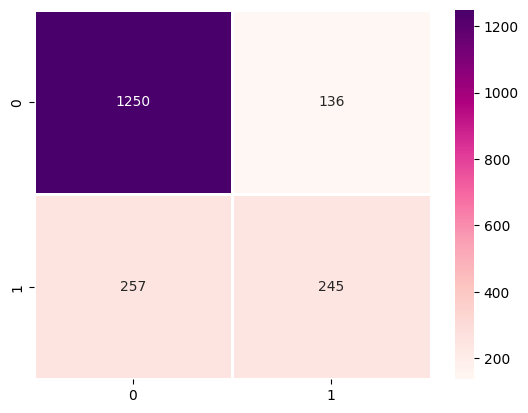

In [65]:
# Confusion Matrix
best_gs_conf_mat = (pd.DataFrame(confusion_matrix(y_test_encoded, best_gs_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_gs_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

In [66]:
logistic_model = LogisticRegression(random_state=27)
logistic_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", logistic_model)])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
        'model__penalty': ['l2'],
    'model__solver' : ['lbfgs', 'liblinear', 'newton-cg'],
    'model__max_iter' : [500,700,1000]
}

# Create the RandomizedSearchCV object
clf = GridSearchCV(logistic_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the RandomizedSearchCV on your training data
search_model = clf.fit(X_train, y_train_encoded)

print("Best parameter (CV score=%0.5f):" % search_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {search_model.best_params_}")


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best parameter (CV score=0.78866):
The best parameters for the GSCV XGB are: {'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'newton-cg', 'model__verbose': 0}


In [67]:

# Predict on the test data
search_pred = search_model.predict(X_test)

# # Get the best hyperparameters
# best_params = search.best_params_

# print(best_params)
# Defining the best version of the model with the best parameters
best_search_model = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model",LogisticRegression(random_state=27,
                              max_iter=500,
                              penalty='l2',
                              solver = 'newton-cg',
                              verbose=0
                              ))])

# Fit the model to the training data
best_search_model.fit(X_train, y_train_encoded)

# Predict on the test data
best_search_pred = best_gs_model.predict(X_test)

print(best_search_pred)

[0 1 0 ... 0 0 0]


<Axes: >

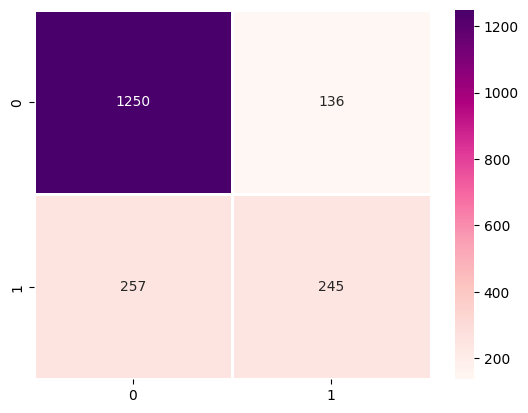

In [68]:
# Confusion Matrix
best_search_conf_mat = (pd.DataFrame(confusion_matrix(y_test_encoded, best_search_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_search_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

In [69]:
cat_model = (CatBoostClassifier(random_state=27))
cat_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", cat_model)])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    #'model__C': uniform(scale=4),
    'model__depth': [6],                   # Depth of the trees
    'model__learning_rate': [0.1,1],          # Learning rate of the model
    'model__l2_leaf_reg': [3],              # L2 regularization term on weights
    'model__rsm': [0.2,0.8],                   # Random Selection Rate (regularization by introducing randomness)
    'model__iterations': [500,800],            # Number of boosting iterations
    'model__loss_function': ['MultiClass'], # Loss function for multi-class classification
    'model__eval_metric': ['Accuracy'],    # Evaluation metric

}

# Create the RandomizedSearchCV object
cat_clf = GridSearchCV(cat_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the RandomizedSearchCV on your training data
cat_gs_model = cat_clf.fit(X_train, y_train_encoded)

print("Best parameter (CV score=%0.5f):" % cat_gs_model.best_score_)
print(f"The best parameters for the GSCV XGB are: {cat_gs_model.best_params_}")


0:	learn: 0.7397351	total: 6.12ms	remaining: 3.05s
1:	learn: 0.7582781	total: 10.4ms	remaining: 2.58s
2:	learn: 0.7649007	total: 13.2ms	remaining: 2.18s
3:	learn: 0.7536424	total: 17ms	remaining: 2.11s
4:	learn: 0.7768212	total: 20.8ms	remaining: 2.05s
5:	learn: 0.7788079	total: 25.9ms	remaining: 2.13s
6:	learn: 0.7807947	total: 29.3ms	remaining: 2.06s
7:	learn: 0.7807947	total: 32.5ms	remaining: 2s
8:	learn: 0.7887417	total: 35.8ms	remaining: 1.95s
9:	learn: 0.7907285	total: 39.3ms	remaining: 1.93s
10:	learn: 0.7907285	total: 43.8ms	remaining: 1.95s
11:	learn: 0.7887417	total: 47.7ms	remaining: 1.94s
12:	learn: 0.7847682	total: 51.6ms	remaining: 1.93s
13:	learn: 0.7880795	total: 54.8ms	remaining: 1.9s
14:	learn: 0.7874172	total: 56.8ms	remaining: 1.83s
15:	learn: 0.7867550	total: 60ms	remaining: 1.82s
16:	learn: 0.7860927	total: 61.9ms	remaining: 1.76s
17:	learn: 0.7887417	total: 65.3ms	remaining: 1.75s
18:	learn: 0.7913907	total: 68.6ms	remaining: 1.74s
19:	learn: 0.7913907	total: 73

In [70]:
# Predict on the test data
cat_gs__pred = search_model.predict(X_test)

# # Get the best hyperparameters
# best_params = search.best_params_

# print(best_params)
# Defining the best version of the model with the best parameters
best_gs_catboost_model = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model",CatBoostClassifier(random_state=27,
                              iterations=500,
                              depth=6,
                              eval_metric = 'Accuracy',
                              l2_leaf_reg=3,
                              learning_rate=0.1,
                              rsm = 0.8,
                              loss_function = 'MultiClass',
                              

                              ))])

# Fit the model to the training data
best_gs_catboost_model.fit(X_train, y_train_encoded)

# Predict on the test data
best_catboost_pred = best_gs_catboost_model.predict(X_test)

print(best_catboost_pred)


0:	learn: 0.7722458	total: 8.01ms	remaining: 4s
1:	learn: 0.7733051	total: 16.2ms	remaining: 4.04s
2:	learn: 0.7897246	total: 22.8ms	remaining: 3.77s
3:	learn: 0.7897246	total: 28.2ms	remaining: 3.49s
4:	learn: 0.7907839	total: 33ms	remaining: 3.26s
5:	learn: 0.7955508	total: 37.5ms	remaining: 3.09s
6:	learn: 0.7966102	total: 42.5ms	remaining: 2.99s
7:	learn: 0.7955508	total: 47.1ms	remaining: 2.89s
8:	learn: 0.8003178	total: 51.8ms	remaining: 2.82s
9:	learn: 0.7981992	total: 56.4ms	remaining: 2.76s
10:	learn: 0.7997881	total: 58.3ms	remaining: 2.59s
11:	learn: 0.7997881	total: 63.5ms	remaining: 2.58s
12:	learn: 0.7966102	total: 70.6ms	remaining: 2.64s
13:	learn: 0.7950212	total: 77.2ms	remaining: 2.68s
14:	learn: 0.7981992	total: 83ms	remaining: 2.68s
15:	learn: 0.8024364	total: 88.5ms	remaining: 2.68s
16:	learn: 0.8029661	total: 94.2ms	remaining: 2.68s
17:	learn: 0.8045551	total: 98.9ms	remaining: 2.65s
18:	learn: 0.8045551	total: 105ms	remaining: 2.65s
19:	learn: 0.8034958	total: 10

<Axes: >

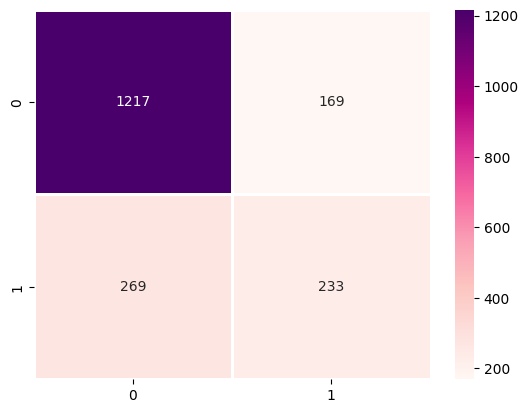

In [71]:
# Confusion Matrix
best_search_conf_mat = (pd.DataFrame(confusion_matrix(y_test_encoded, best_catboost_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_search_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

In [72]:
svc_model = SVC(random_state=27)
svc_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", svc_model)])

# Define the parameter distributions for GridSearchCV
param_distributions = {
    
    'model__break_ties': [True],                   
    'model__kernel': ['linear','rbf','poly'],         
    'model__max_iter': [-1],              
    'model__coef0': [0.0,0.2],                
    'model__probability': [True ],           
    'model__shrinking': [True,False], 
    'model__verbose': [True],    
    'model__tol' : [0.0001,0.1]
}

# Create the GridSearchCV object
svc_clf = GridSearchCV(svc_pipeline, param_grid=param_distributions, scoring = 'accuracy',error_score='raise')

# Fit the GridSearchCV on your training data
svc_gs_model = svc_clf.fit(X_train, y_train_encoded)

print("Best parameter (CV score=%0.5f):" % svc_gs_model.best_score_)
print(f"\nThe best parameters for the GSCV XGB are: {svc_gs_model.best_params_}")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Best parameter (CV score=0.79184

In [73]:
# Defining the best version of the model with the best parameters
best_gs_svc_model = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model",SVC(random_state=27,
                              break_ties=True,
                              coef0 = 0,
                              kernel = 'linear',
                              probability = True,
                              max_iter =-1,
                              shrinking = True,                                                      
                              ))])

# Fit the model to the training data
best_gs_svc_model.fit(X_train, y_train_encoded)

# Predict on the test data
best_svc_pred = best_gs_svc_model.predict(X_test)

print(best_svc_pred)

[0 1 0 ... 0 0 0]


<Axes: >

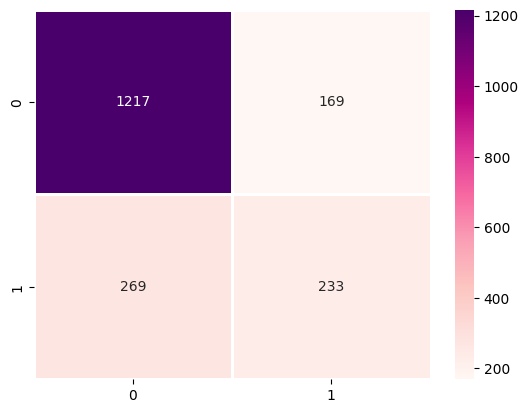

In [74]:
# Confusion Matrix
best_svc_conf_mat = (pd.DataFrame(confusion_matrix(y_test_encoded, best_svc_pred)).reset_index(drop=True))

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_search_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)

#### `Testing one of the models with the test data set`

In [75]:
test_data = pd.read_excel('data\\Telco-churn-last-2000.xlsx')
test_data = cleaner(test_data)
best_svc_pred = best_gs_svc_model.predict(test_data)

print(best_svc_pred)


[1 0 0 ... 0 0 0]


#### `Persit the model`

In [76]:


for name, model_pipeline in all_models_pipelines.items():
    joblib.dump(model_pipeline,f'models\{name}.joblib')


In [77]:
joblib.dump(best_gs_pred ,'models\\tuned\\best_gs_pred .joblib')
joblib.dump(best_search_pred,'models\\tuned\\best_search_pred.joblib')
joblib.dump(best_catboost_pred,'models\\tuned\\best_catboost_pred.joblib')
joblib.dump(best_svc_pred,'models\\tuned\\best_svc_pred.joblib')

['models\\tuned\\best_svc_pred.joblib']